<a href="https://colab.research.google.com/github/1972007/ml-c22-pc390/blob/main/C22_PC390.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Skin Disease Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle

In [3]:
#Yang lain
from google.colab import files
json_kaggle = files.upload()
! cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [4]:
#! kaggle datasets download shubhamgoel27/dermnet
# Ide dataset : https://www.kaggle.com/datasets/ammarabbasi1040/skin-diseases-dataset
#! kaggle datasets download ismailpromus/skin-diseases-image-dataset
! kaggle datasets download ammarabbasi1040/skin-diseases-dataset

 96% 409M/424M [00:04<00:00, 104MB/s]
100% 424M/424M [00:04<00:00, 95.1MB/s]


In [5]:
import zipfile
#local_zip = "/content/dermnet.zip"
#dest_zip = "/content/dermnet"
# local_zip = "/content/skin-diseases-image-dataset.zip"
# dest_zip = "/content/skin-diseases-image-dataset"
local_zip = "/content/skin-diseases-dataset.zip"
dest_zip = "/content/skin-diseases-dataset"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(dest_zip)
zip_ref.close()

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
import os
import shutil

In [7]:
def move_files(dir1, dir2):
  folder=os.listdir(dir1)
  for filee in folder:
    shutil.move(os.path.join(dir1, filee), dir2)

os.mkdir("/content/skin-diseases-dataset/test")
os.mkdir("/content/skin-diseases-dataset/train")
move_files("/content/skin-diseases-dataset/Test_Data/Test_Data", "/content/skin-diseases-dataset/test")
move_files("/content/skin-diseases-dataset/Train__/Train__", "/content/skin-diseases-dataset/train")
os.rmdir("/content/skin-diseases-dataset/Train__/Train__")
os.rmdir("/content/skin-diseases-dataset/Test_Data/Test_Data")
os.rmdir("/content/skin-diseases-dataset/Train__")
os.rmdir("/content/skin-diseases-dataset/Test_Data")

In [8]:
img_dir_example = "/content/skin-diseases-dataset/test/Actinic_Keratosis/Actinic_Keratosis_original_ISIC_0010512.jpg_2f84b911-a928-4635-bc1b-8f4a79d6af4f.jpg"
im = Image.open(img_dir_example)
img_size = im.size
print(img_size)

(320, 320)


In [9]:
# filePath = "/content/dermnet"
# trainPath = "/content/dermnet/train/"
# testPath = "/content/dermnet/test/"
filePath = "/content/skin-diseases-image-dataset"
fileSrc = "/content/skin-diseases-image-dataset/IMG_CLASSES"
trainPath = "/content/skin-diseases-dataset/train"
testPath = "/content/skin-diseases-dataset/test"
folderr = sorted(os.listdir(trainPath))
print(folderr)

['Actinic_Keratosis', 'Benign_Keratosis', 'Eczema', 'Melanocytic Nevi', 'Psoriasis', 'Ringworm']


In [10]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_gen = train_datagen.flow_from_directory(directory=trainPath,
                                              batch_size=128,
                                              class_mode='categorical',
                                              target_size=img_size)

valid_datagen = ImageDataGenerator(rescale=1/255.0)
valid_gen = train_datagen.flow_from_directory(directory=testPath,
                                              batch_size=128,
                                              class_mode='categorical',
                                              target_size=img_size)

Found 27423 images belonging to 6 classes.
Found 3005 images belonging to 6 classes.


In [11]:
output = len(folderr)
print(output)
activation = "softmax"
loss = "categorical_crossentropy"
if output < 2 :
  activation = "sigmoid"
  loss = "binary_crossentropy"

6


In [12]:
#MobileNet transfer learning
import tensorflow_hub as hub
do_fine_tuning = False
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_size) + (3,)),
    tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(output,activation=activation)
  ])

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])

In [ ]:
#Model from scratch
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(output,activation=activation)
])
 

model.compile(optimizer="adam",
              loss=loss,
              metrics=['accuracy'])

In [ ]:
img_size + (3,)

(320, 320, 3)

In [13]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=valid_gen)   

Epoch 1/10
215/215 [==============================] - 671s 3s/step - loss: 0.7809 - accuracy: 0.6907 - val_loss: 0.9449 - val_accuracy: 0.6263
Epoch 2/10
215/215 [==============================] - 637s 3s/step - loss: 0.5825 - accuracy: 0.7695 - val_loss: 0.8670 - val_accuracy: 0.6639
Epoch 3/10
215/215 [==============================] - 638s 3s/step - loss: 0.5247 - accuracy: 0.7944 - val_loss: 0.8288 - val_accuracy: 0.6739
Epoch 4/10
215/215 [==============================] - 639s 3s/step - loss: 0.4903 - accuracy: 0.8071 - val_loss: 0.9672 - val_accuracy: 0.6346
Epoch 5/10
215/215 [==============================] - 636s 3s/step - loss: 0.4686 - accuracy: 0.8175 - val_loss: 0.8858 - val_accuracy: 0.6729
Epoch 6/10
215/215 [==============================] - 636s 3s/step - loss: 0.4401 - accuracy: 0.8292 - val_loss: 0.8948 - val_accuracy: 0.6562
Epoch 7/10
215/215 [==============================] - 650s 3s/step - loss: 0.4260 - accuracy: 0.8355 - val_loss: 0.7784 - val_accuracy: 0.7215

In [14]:
model.save("skin-diseases-image-dataset_model_v_augment_mobilenet.h5")

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model = tf.keras.models.load_model("test.h5")

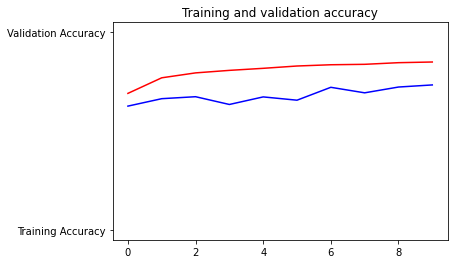

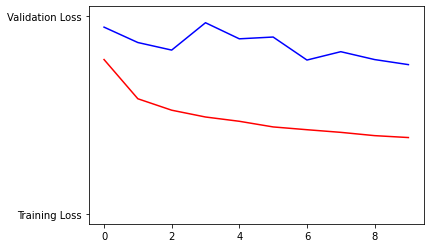

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


uploaded = files.upload()
for k, v in uploaded.items():
  img = image.load_img(k, target_size=img_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)

  images = np.vstack([x])
  classes = model.predict(images,batch_size=10)
  print(k)
  print(classes)


['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


Saving download.jpg to download.jpg
download.jpg
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
